In [1]:
from scipy import stats
import numpy as np

# Approximate Bayesian Computation

Generative models are models which we can generate new data with. Often we do not know an explicit formulation for a generative model (They are black-boxes), especially when they occur in the real-world. Mathematically, generative models are those which capture the distribution of $\mathbb{P}(X,Y)$ where $X,Y$ are observed data and its labels, rather than $\mathbb{P}(Y|X)$ which discriminative models capture.

Approximate Bayesian Computation (ABC) is a family of computational methods, based on Bayesian Statistics, which use simulation to estimate the posterior for parameter values for theorised models, without having to evaluate the likelihood function.

These simulated values can then be used to either produce an estimate of the whole posterior (using methods such as kernel density estimation) or to estimate quantities from the posterior (commonly, its mean). These estimations can then be used to fit a theorised model's parameters.

In this notebook I introduce and demonstrate a few ABC algorithms which I have implemented in `ABC.py`.

**Table of Contents**
 * [Motivation](#Motivation-for-ABC)
 * [Modelling](#Modelling)
     * [Models.LinearModels](#Models.LinearModel)
     * [Models.ExponentialModels](#Models.ExponentialModels)
 * [Kernels](#Kernels-$K_\epsilon$)
 * [Summary Statistics](#Summary-Statistics-$s$)
     * [Sufficiency](#Sufficiency)
 * [ABC Algorithms](#ABC-Algorithms)
     * [Components of ABC](#Components-of-ABC)
     * [ABC-Rejection Sampling](#ABC-Rejection-Sampling)
         * [Implementation](#rejection_implementation)
             * [Linear Model](#rejection_linear_model)
             * [Exponential Model](#rejection_exponential_model)
     * [ABC-MCMC](#ABC-MCMC)
         * [Implementation](#mcmc_implementation)
             * [Linear Model](#mcmc_linear_model)
             * [Exponential Model](#mcmc_exponential_model)
     * [ABC-SMC](#ABC-SMC)
         * [Implementation](#smc_implementation)
             * [Linear Model](#smc_linear_model)
             * [Exponential Model](#smc_exponential_model)
 * [Discussion](#Discussion)
     * [Limitations](#Limitations)
     * [Decisions](#Decisions-to-make-in-each-algorithm)
     * [When problems occur](#When-problems-occur)
 * [Demonstrations](#Demonstrations)
     * [Models with Multi-Modal Likelihoods & Posteriors](#Models-with-Multi-Modal-Likelihoods-&-Posteriors)
     * [Insufficient Statistics](#Insufficient-Statistics)
     * [Choices Matter](#Choices-Matter)
     * [Auto-Correlation](#Auto-Correlation)

## Motivation for ABC
Consider a set of $n$ observations from the model we intend to fit to $Y_{obs}=\{y_{obs,1},\dots,y_{obs,n}\}$ with $y_{obs,i}\in\mathbb{R}^m$ and a simulation $Y=\{y_1,\dots,y_n\}$ with $y_i\in\mathbb{R}^m$ with the theoretical model parameterised by $\theta$.

To fit our theorised model we want to determine the posterior for the parameters $\theta$ given the observed data $Y_{obs}$.

$$ \mathbb{P}(\theta|Y_{obs}) $$

Bayes' Rule gives the following formulation for this posterior

$$ \mathbb{P}(\theta|Y_{obs})=\dfrac{\mathbb{P}(Y_{obs}|\theta)\mathbb{P}(\theta)}{\mathbb{P}(Y_{obs})} $$

As we are only interested the ratio of weight the posterior gives to each possible $\theta$, we can ignore the evidence term $\mathbb{P}(\theta)$ as its only job is to normalise the posterior to be a probability distribution.

We define the prior $\mathbb{P}(\theta)$ for our model, ideally encoding some prior knownledge. Thus, the only task left if to calculate the likelihood $\mathbb{P}(Y_{obs}|\theta)$. For most real world scenarios this calculation is intractable (both mathematically and computationally). ABC provides methods for getting around this.

## Modelling

In [2]:
from Models import LinearModel,ExponentialModel

The program `Models.py` provides a framework for defining generative models.

`Models.Model` is an *interface* which you need to implement for each model in order for my later methods to work. I have implemented some common models 
 * `Models.LinearModel`, $\theta_0+\sum\theta_iX_i$.
 * `Models.ExponentialModel`, $\theta_0\exp\{X\theta_1\}$.

The "generative" nature of these models is realised by making them "time-series" models and ensuring the same set of values are returned each time the exact same object is queried.

### `Models.LinearModel`
Below I implement the linear model `lm` with mathematical formulation
$$ f(X)=1+10X+\varepsilon\text{ where }\varepsilon\sim\mathcal{N}(0,30) $$

I specify that this model is only observed at values $X=\{1,2,\dots,10\}$ (and in that order). This model generates a single observation of dimension 10, $y_1\in\mathbb{R}^{10}$.

In [3]:
# Specify the model
np.random.seed(16111998) # Fix random seed
lm=LinearModel(
    n_params=2,
    params=[1,10],
    n_vars=1,
    n_obs=10,
    x_obs=[[x] for x in range(10)],
    noise=30,
)

# Observe the model (will be the same each time this object is observed)
lm.observe()

[[2.950068147167192],
 [6.582033773389246],
 [19.352977309887507],
 [23.073409099211318],
 [42.002592041406075],
 [46.240787044118285],
 [56.52241872907294],
 [75.75469430652853],
 [89.52725765204846],
 [96.057868970883]]

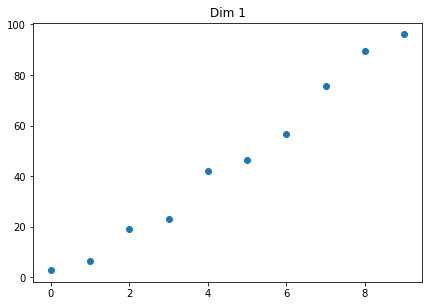

In [4]:
# Plot the observations
lm.plot_obs()

### `Models.ExponentialModel`
Below I implement the exponential model `em` with mathematical formulation
$$ f(X)=2e^{3X/10}+\varepsilon\text{ where }\varepsilon\sim\mathcal{N}(0,1) $$
Again, I specify that this model is only observed at values $X=\{1,2,\dots,10\}$ (and in that order). This model generates a single observation of dimension 10, $y_1\in\mathbb{R}^{10}$.

In [5]:
# Specify the model
np.random.seed(16111998) # Fix random seed
em=ExponentialModel(
    params=[2,.3],
    n_obs=10,
    x_obs=[[x] for x in range(10)],
    noise=1,
)

# Observe the model (will be the same each time this object is observed)
em.observe()

[array([3.3560321]),
 array([2.54325222]),
 array([3.52141497]),
 array([3.01241223]),
 array([5.50316435]),
 array([5.61277964]),
 array([7.23215671]),
 array([11.03425435]),
 array([14.5800335]),
 array([17.80316803])]

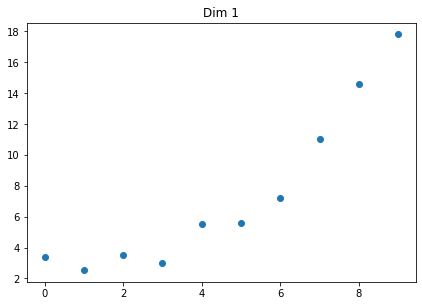

In [6]:
# Plot the observations
em.plot_obs()

## Kernels $K_\epsilon$
Kernels are functions which are used compare data by making it linearly seperable. Kernels are used in ABC to determine how similar simulated data is to observed data.

Most kernels have "bandwidth" parameter $\epsilon$ which specifies how similar data needs to be. A greater bandwidth means data doesn't need to be as similar, this leads to more observations being accepted and quicker computation, but decreased accuracy.

Here are some popular kernels for ABC
 * Uniform Kernel $K_\epsilon(x)=\mathbb{1}\{|x|\leq\epsilon\}$.
 * Epanechnikov Kernel $K_\epsilon(x)=\frac3{4\epsilon}\left(1-\frac{x^2}{\varepsilon^2}\right)\mathbb{1}\{|x|\leq\epsilon\}$.
 * Gaussian Kernel $K_\epsilon(x)=\frac1{\sqrt{2\pi}}\exp\left\{-\frac12x^2\right\}$
 
In ABC $x=\|s-s_{obs}\|\in\mathbb{R}$ where $s$ is the summary statistic value of a sample, $s_{obs}$ is the summary statistic value of the originally observed data and $\|\cdot\|$ is some distance measure (Typically euclidean).
 
These kernels return a weighting which is often interpretted, in ABC, as the probability that we accept a given simulation. In practice we sample from $p\sim\mathcal{U}[0,1]$ and if $p>K_\epsilon(x)$ then we accept the simulation.

## Summary Statistics $s$
*I discuss summary statistics in depth in [SS_Notebook](SS_Notebook.ipynb).*

A Summary statistic is a projection of high-dimensional data to a lower dimensional space.

$$ s:\mathbb{R}^m\to\mathbb{R}^p\text{ with }p\ll m $$

In ABC several summary statistics are applied to observed and simulated data in order to reduce the total dimensionality of data and thus reduce the computational requirements of each algorithm. The use of summary statistics is often required just to make the algorithms computationally tractable.

Greater reduction in dimensionality leads to more data being lost meaning the posterior produced by ABC is less accurate and less stable. This means the trade-off is between computational efficiency and model accuracy.

In most settings observed and simulated data consist of multiple observations each with multiple dimension meaning that summary statistics in ABC typically have the following signature
$$ s:\mathbb{R}^{n\times m}\to\mathbb{R}^p\text{ with }p\ll n\times m $$
where $n$ is the number of observations, $m$ is the dimension of each observation and $p$ is the dimension of the summary.

Moreover, as ABC uses several summary statistics and each can map to a different dimension we what $\sum p_i\ll n\times m$ where $\{p_1,\dots,p_k\}$ are the dimensions of the summaries produced by $k$ different summary statistics.

**Note**
When using multiple summary statistics more questions arise about which (if any) are more important. 

### Sufficiency
A set of summary statistics $S=\{s_1,\dots,s_k\}$ are said to be "Sufficient" if they carry enough data in order to fully determine the parameters of a model.
$$ \mathbb{P}(X|S(X),\theta)=\mathbb{P}(X|S(X))\text{ where }X\sim f_\theta(\cdot) $$

The *Pitman–Koopman–Darmois Theorem* states that sufficient sets of summary statistics only exist for distributions from the exponential family. As most real world distributions do not come from the exponential family this means we need to consider other qualities.

"Approximate Sufficiency" is a metric for finding sets of summary statistics whcih statisfy some optimality condition to do with sufficiency, and can be applied to any distribution.

## ABC Algorithms

In [7]:
import ABC

# Size plots
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

### Components of ABC
To perform ABC we typically need/define the following features
 * A set of $n$ observations $Y_{obs}=\{y_{obs,1},\dots,y_{obs,n}\}$ from our generative model with $y_{obs,i}\in\mathbb{R}^m$ for large $m$.
 * A theorised model $f_\theta(\cdot)$ for the generative model, which can be simualted from. (See [Modelling](#Modelling))
 * A prior $\pi_0(\cdot)$ for each parameter of the theorised model.
 * A set of summary statistics $s:\mathbb{R}^m\to\mathbb{R}^k$ mapping each observation $y_i$ to a lower dimension. (See [Summary Statistics](#Summary-Statistics-$s$))
 * A kernel $K_\epsilon(\cdot)$ with bandwith $\epsilon$. (See [Kernels](#Kernels))
 * A distance measure $\|\cdot\|$.

### ABC-Rejection Sampling
The rejection sampling algorithm is the simplist implementation of ABC.

The general premise is to keep randomly initialising and simulating our theorised model until enough "good" simulations have occured. A simulation is deemed "good" if it is sufficiently close to observed data from the true model.

**Algorithm**

Consider the setup described [above](#Components-of-ABC). Here is an algorithm for ABC-Rejection Sampling
<ol>
  <li>
      Calculate the summary statistic values $s_{obs}$ from the observed data $Y_{obs}$.
      $$ s_{obs}=s(Y_{obs}) $$
  </li>
  <li>
      Repeat the followingUntil stopping condition is reached
  </li>
    <ol>
      <li>
          Sample a set of parameters $\tilde\theta_t$ from the priors $\pi_0(\theta)$.
          $$ \tilde\theta_t\sim\pi_0(\theta) $$
      </li>
      <li>
          Initialise the theorised model $f_{\tilde\theta_t}$ with the sampled parameters $\tilde\theta_t$ and simulate data $Y_t$.
        $$ Y_t\sim f_{\tilde\theta_t}(Y) $$
      </li>
      <li>
          Calculate the summary statistic values $s_t$ for the simulate data $Y_t$.
        $$ s_t=s(Y_t) $$
      </li>
      <li>
          Reject this simulation with probability $K_\epsilon(\|s_t-s_{obs}\|)$.
          <br>If the simulation is accepted then record the parameter values $\tilde\theta_t$ and summary statistic $s_t$.
      </li>
    </ol>
  <li>
    Return the accepted parameter values $\{\tilde\theta_1,\dots,\tilde\theta_N\}$.
  </li>
</ol>

Different variations on this algorithm have different stopping conditions:
 * *Fixed Number* ("Stop once $N$ simulations have been accepted"). Good as we can define how good a simulation needs to be accepted. Bad as an unknown number of simulations will be performed.
 * *Best Samples* ("Perform $M$ simulations and keep the best $N$"). Good as the algorithm will perform a known number of simulations. Bad as we cannot control how good the accepted simulations will be.

<a id="rejection_implementation"></a>
### Implementation
Here I shall demonstrate my implementation of the ABC-Rejection Sampling algorithm.

But first some details about my implementation:
 * In the *Fixed Number* variation, when using multiple summary statistics the distance function $\|\cdot\|$ is applied to each (simulated,observed) summary statistic pair, the $L_1$-Norm of these distances is then passed through the kernel to determine the probability that a simulation is accepted.
 * In the *Best Samples* variation, when using multiple summary statistics each simulation is given a weighting equal to the $L_1$-Norm of the distances between the observed and simulated summary statistic values. The simulations with the $N$ lowest weights are accepted.
 * The $L_2$-Norm is used as the distance function.
 
The distance functions and norms used here are worthy of further discussion. [TODO](#TODO)

<a id="rejection_linear_model"></a>
**Linear Model**

First I shall use the linear model defined [above](#Models.LinearModel). The true model here is $f(X)=1+10X+\varepsilon$ with $\varepsilon\sim\mathcal{N}(0,30)$ and my theorised model is $f_\theta(X)=\theta_0+\theta_1X$ (I am not going to estimate the variance of the additive noise).

Below I run the algorithm twice:
 * First time stops once 100 simulations have been accepted. Acceptance is determined by using a uniform kernel with bandwith $\epsilon=.7$.
 * Second time runs 1,000 simulations and uses the best 100.

In both cases the returned `fitted_model` uses the mean of the accepted values for each parameter. All simulations are given even weighting in this mean, but this could be extended to give greater weight to simulations which produce summary statistics which are close to $s_{obs}$.

**Priors**

For the priors I am using $\pi_{0}(\theta_0)\sim\mathcal{U}[0,6]$ and $\pi_0(\theta_1)\sim\mathcal{U}[8,14]$. These priors are informative as they do include the true values for each parameter, but the expected value of each prior is not the true value of the parameter.

In [8]:
# Define Priors
lm_priors=[stats.uniform(0,6),stats.uniform(8,6)]

**Summary Statistics**

I have chosen two summary statistics
 * $s_0$ - 10 times value of the first observation.
 * $s_1$ - Mean change in value between consecutive observations.
 
$s_0$ has a factor of 10 so that its values are approximaltely equal to $s_1$ and so should have equal influence on the outcome.

In [9]:
# Define Summary Statistics
start = (lambda ys:[10*ys[0][0]])
mean_grad = (lambda ys:[np.mean([ys[i+1][0]-ys[i][0] for i in range(len(ys)-1)])])
summary_stats=[start,mean_grad]

(1,122) 100/100



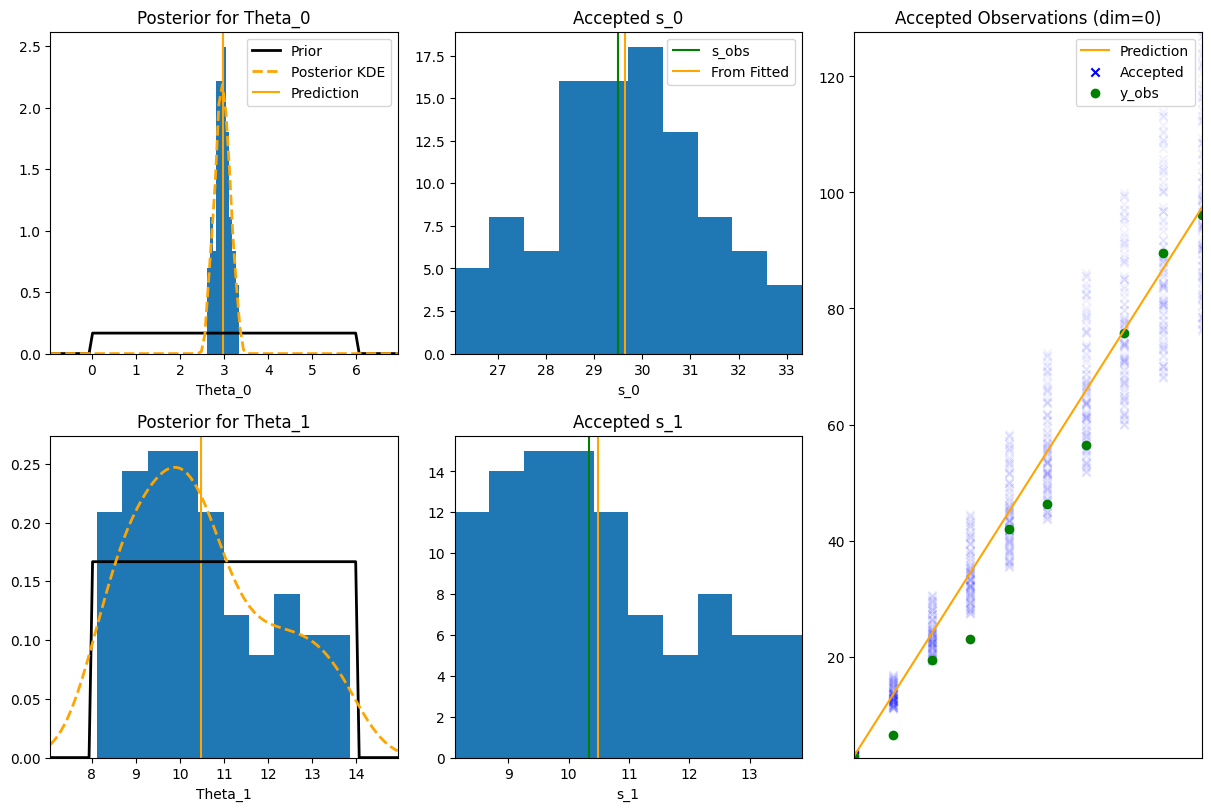

True Model - 1.000+10.000*x0+N(0,30.000)
Fitted Model - 2.963+10.484*x0

Wall time: 11.3 s


In [10]:
%%time
# First Run - FIXED NUMBER - Until 100 acceptances
np.random.seed(16111998) # Fix random seed

sampling_details={"sampling_method":"fixed_number","sample_size":100,"scaling_factor":4,"kernel_func":ABC.uniform_kernel}

fitted_model,_=ABC.abc_rejcection(n_obs=10,y_obs=lm.observe(),fitting_model=lm.copy([1,1]),priors=lm_priors,sampling_details=sampling_details,summary_stats=summary_stats)
print("True Model - {}".format(lm))
print("Fitted Model - {}\n".format(fitted_model))

*Comments*

1,122 simulations were required for 100 to be accepted.

The returned fitted model was $\hat{f}(X)=2.963+10.484$ which shows a good fit for the second coefficient, but not for the first. This is due to noise in the true model meaning that the first data point has value $\sim2.95$. Looking at the plot of the fitted model and accepted simulations (RHS), we can see that despite noise meaning many data points do not lie near their true value, the fitted model is very good.

The histograms for the accepted values of each summary statistic (middle col) show that the values which were accepted were very close to the true values for all summary statistics. This is to be expected due the summary statistics being chosen so they both had similar influence on the weighting applied.

The distributions for each parameter (left col) shows that the posteriors have a significantly different shape to the priors, indicating that significant learning has occurred. Moreover, a significant amount of weight in the posteriors is placed near the true parameter values. It is notable though that the posterior for $\theta_0$ is significantly more different from the prior for $\theta_0$, than the posterior for $\theta_1$ is from its respective prior.

(999/1,000)



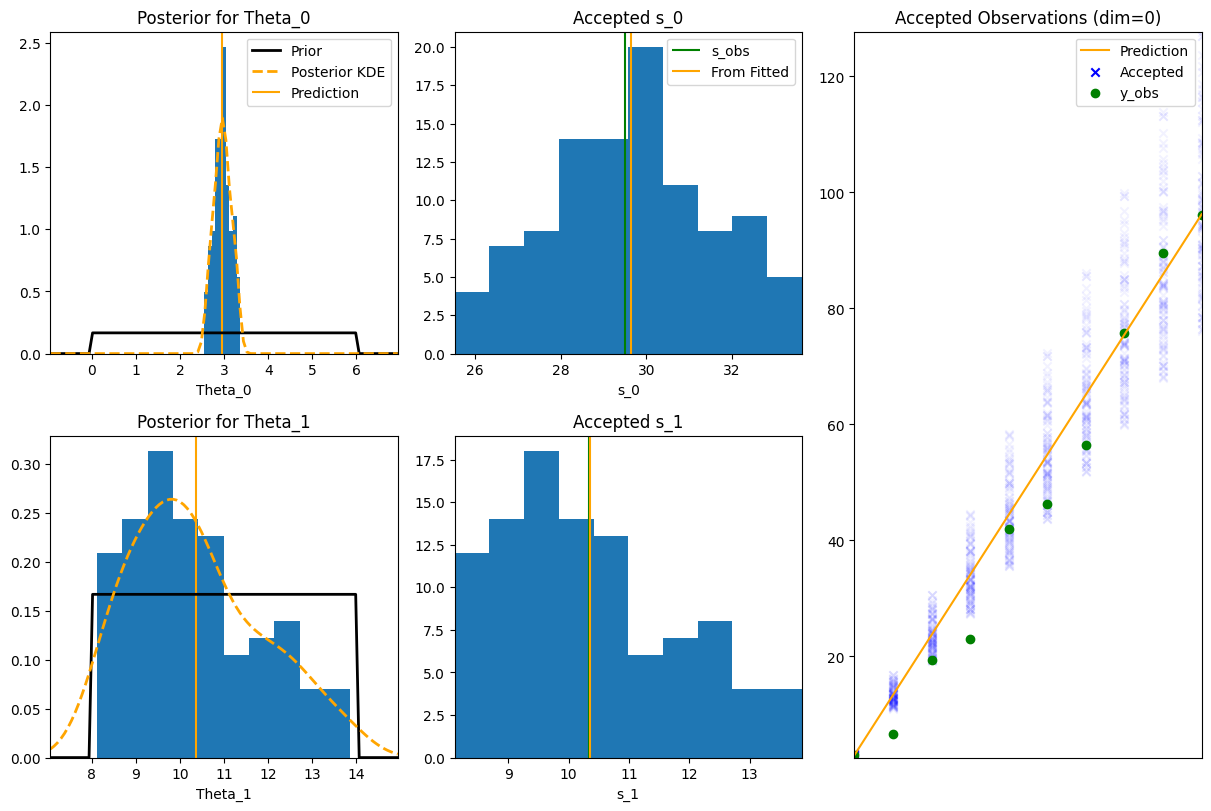

True Model - 1.000+10.000*x0+N(0,30.000)
Fitted Model - 2.963+10.363*x0

Wall time: 10.2 s


In [11]:
%%time
# Second Run - BEST SAMPLES - 10,000 simulations keeping best 100
np.random.seed(16111998) # Fix random seed

sampling_details={"sampling_method":"best","num_runs":1000,"sample_size":100}

fitted_model,_=ABC.abc_rejcection(n_obs=10,y_obs=lm.observe(),fitting_model=lm.copy([1,1]),priors=lm_priors,sampling_details=sampling_details,summary_stats=summary_stats)
print("True Model - {}".format(lm))
print("Fitted Model - {}\n".format(fitted_model))

*Comments*

The returned fitted model was $\hat{f}(X)=2.963+10.363X$. This is very similar to the model returned by the *Fixed Number* variation above.

The posteriors produced by this variation are practically identical to those produced by the fixed number variation above.

<a id="rejection_exponential_model"></a>
**Exponential Model**

Now I shall use the exponential model defined [above](#Models.ExponentialModel). The true model here is $f(X)=2\exp(3X/10)+\varepsilon$ with $\varepsilon\sim\mathcal{N}(0,1)$ and my theorised model is $f_\theta(X)=\theta_0\exp(\theta_1X)$. (I am not going to estimate the variance of the additive noise).

I only run the *Best Samples* variation of the algorithm, performing 1,000 simulations and accepting the best 100. I do not run both variations as I just wish to demonstrate that ABC-Rejection Sampling works on the slightly more complicated exponential model.

The returned `fitted_model` uses the mean of the accepted values for each parameter.

**Priors**

For the priors I am using $\pi_{0}(\theta_0)\sim\mathcal{U}[0,3]$ and $\pi_0(\theta_1)\sim\mathcal{U}[0,1]$. These priors are informative as they do include the true values for each parameter, but the expected value of each prior is not the true value of the parameter.

In [12]:
# Define Priors
em_priors=[stats.uniform(0,3),stats.uniform(0,1)]

**Summary Statistics**

I have chosen three summary statistics
 * $s_0$ - Value of the first observation.
 * $s_1$ - 10 times Mean $\log$-change in value between consecutive observations.
 
$s_1$ has a factor of 10 so that its values are approximaltely equal to $s_0$ and so should have equal influence on the outcome.

In [13]:
# Define Summary Statistics
start = (lambda ys:[ys[0][0]])
mean_log_grad = (lambda ys:[10*np.mean([np.log(max(1,ys[i+1][0]-ys[i][0])) for i in range(len(ys)-1)])])
summary_stats=[start,mean_log_grad]

(999/1,000)



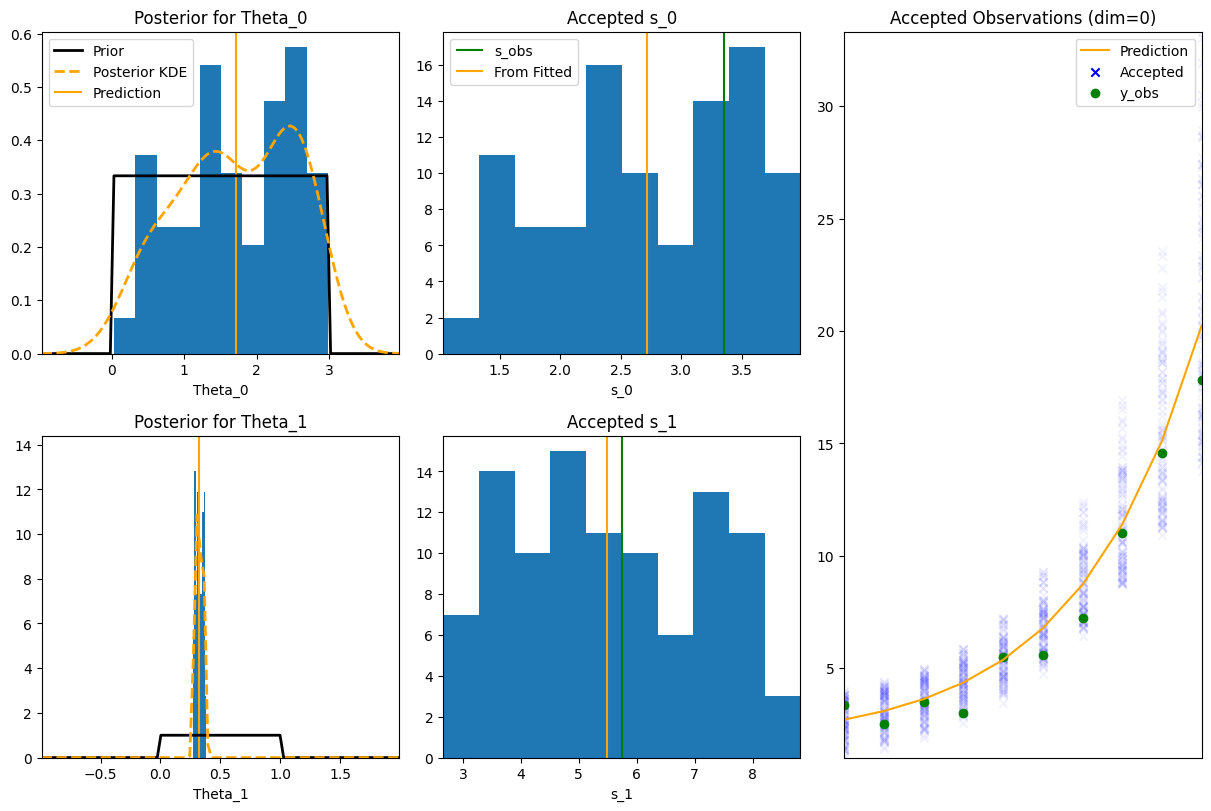

True Model - 2.000*e^(0.300*x0)+N(0,1.000)
Fitted Model - 1.716*e^(0.324*x0)

Wall time: 10.1 s


In [14]:
%%time
# Second Run - BEST SAMPLES - 10,000 simulations keeping best 100
np.random.seed(16111998) # Fix random seed
sampling_details={"sampling_method":"best","num_runs":1000,"sample_size":100}

fitted_model,_=ABC.abc_rejcection(n_obs=10,y_obs=em.observe(),fitting_model=em.copy([1,1]),priors=em_priors,sampling_details=sampling_details,summary_stats=summary_stats)
print("True Model - {}".format(em))
print("Fitted Model - {}\n".format(fitted_model))

*Comments*

The returned fitted model is $\hat{f}(X)=1.716\exp(0.324X)$. This shows a very good fit for $\theta_1$ but not for $\theta_0$. The posterior for $\theta_0$ is practically unchanged from its prior. Moreover, the fitted value $\hat\theta_0$ likely is just the mean of the prior assigned to $\theta_0$ (Indicating no learning has occured for $\theta_0$). While, the posterior for $\theta_1$ places almost all its weight on the true value.

This shows us that $\theta_1$ is a significantly more important parameter when fitting an exponential model than $\theta_0$. This can be seen by noting (in the right-hand plot) how well the fitted model fits the observed data.

### ABC-MCMC
The Markov Chain Monte Carlo (MCMC) version of ABC aims to search the parameter space in a much more informed way than ABC-Rejection Sampling.

The general premise of ABC-MCMC is to initally random search the parameter space until a good set of parameters are found; Then over a fixed number of steps: perturb this set of parameters, if the perturbed parameters are accepted by the kernel then accept them and use them going forwards (otherwise revert).

Further to [Components of ABC](#Components-of-ABC), ABC-MCMC requires a perturbance kernel $K^*(\cdot)$ which slightly changes a set of parameters, creating a random walk in the parameter space. A simple perturbance kernel is to add some gaussian noise.

**Algorithm**

Consider the setup described [above](#Components-of-ABC) and a perturbance kernel $K^*(\cdot)$. Here is an algorithm for ABC-MCMC with a chain of length $N$.
<ol>
  <li>Calculate the summary statistic values $s_{obs}$ from the observed data $Y_{obs}$
    $$ s_{obs}=s(Y_{obs}) $$</li>
  <li><i>Burn In</i></li>
  <ol>
    <li>Sample a set of parameters $\tilde\theta_0$ from the priors $\pi_0(\theta)$.
    $$ \tilde\theta_0\sim\pi_0(\theta) $$</li>
    <li>Initialise the theorised model $f_{\tilde\theta_0}$ with the sampled parameters $\tilde\theta_0$ and simulate data $Y_0$
$$ Y_0\sim f_{\tilde\theta_0}(Y) $$</li>
    <li>Calculate the summary statistic values $s_0$ for the simulated data $Y_0$.
$$ s_0=s(Y_0) $$</li>
    <li> Accept this simulation with probability $K_\epsilon(\|s_0-s_{obs}\|)$. If the simulation is accepted set $t=0$ and move to the <i>3. MCMC Step</i></li>
  </ol>
    <li><i>MCMC Step</i></li>
  <ol>
    <li>Perturb the previously accepted parameter values $\tilde\theta_t$ to get a new set of parameters $\theta^*$
    $$ \theta^*=K^*(\tilde\theta_t) $$</li>
    <li>Initialise the theorised model $f_{\theta^*}$ with the perturbed parameters $\theta^*$ and simulate data $Y_{t+1}$
    $$ Y_{t+1}\sim f_{\theta^*}(Y) $$</li>
    <li>Calculate the summary statistic values $s_{t+1}$ for the simulated data $Y_{t+1}$.
$$ s_{t+1}=s(Y_{t+1}) $$</li>
    <li>Accept this simulation with probability $K_\epsilon(\|s_{t+1}-s_{obs}\|)$. If the simulation is accepted set $\tilde\theta_{t+1}=\theta^*$, otherwise set $\tilde\theta_{t+1}=\tilde\theta_t$</li>
    <li>Increment $t$</li>
  </ol>
  <li>Return the accepted parameter values $\{\tilde\theta_1,\dots,\tilde\theta_N\}$.</li>
</ol>

**Extensions**
It is easy for ABC-MCMC to get stuck if it steps into a region of low posterior density. There are a few extensions to the algorithm above to counter this (some of which can be combined), inc.
 * Run multiple chains.
 * Every time a simulation is rejected, losen the acceptance criteria. (Reset them when a simulation is accepted).
 * If a simulation has not been accepted in $M$ iterations, repeat the burn-in process.

Running multiple chains is a good idea as the burn-in step can mean that only one part of the posterior is explored. This is especially bad if the posterior is multi-modal. However, this either means more simulations need to be done total or each chain performs fewer.

<a id="mcmc_implementation"></a>
### Implementation

Here I implement the ABC-MCMC algorithm and apply it to the same [model](#Models.LinearModel) & [exponential model](#Models.ExponentialModel) as I did for the [ABC-Rejection Sampling](#rejection_implementation). To allow for a fair comparison of the algorithms I am using the same *Summary Statistics* and *Priors* for each model.

For both models I ran the algorithm for a chain-length of 2,500 and tuned the bandwidths st the acceptance rate was ~40% in both cases. This rate of acceptance should avoid auto-correlation in the MCMC-chain.

**Perturbance Kernels**<a id="mcmc_perturbance"></a>

Choosing optimal pertubance kernels is non-trivial as we need to consider their computational requirements and how efficient they are at exploring. Moreover, a more efficient kernel means that we can that can perform more simulations for the same computational requirement. See [this paper](https://drive.google.com/file/d/1-aHMmEIwfag23I81aW-C87UyOBRiq7rK/view?usp=sharing) for an in-depth review. Most perturbance kernels are centred around the input.

I chose to use a kernel which applies additive gaussian noise to the input. This kernel is equivalent to sampling $\tilde\theta\sim\mathcal{N}(\theta,\sigma^2I)$. Greater variance means that more of the parameter space can be explored in fewer simulations, however it is more likely a simulation will be reject as it is more likely the perturbed parameters fall outside areas of high posterior density. I use the same variance ($\sigma^2=.5$) for each dimension, but this can easily be extended to have a different variance for each dimension.

More complex kernels may consider:
 * Correlations between parameters, moving correlated parameters in similar directions.
 * Utilise Fisher Information to determine which parameters should be explored the most.
 
Tunning a perturbance kernel should be done in tandem with tuning the acceptance kernel as both affect the proportion of new simulations which are accepted. When tuning you should define a target proportion of new simulations to be accepted (~10\%) and tune accordingly.

In [15]:
perturbance_kernels = [lambda x:x+stats.norm(0,.5).rvs(1)[0]]*2

<a id="mcmc_linear_model"></a>
**Linear Model**

The true model is $f(X)=1+10X+\varepsilon$ where $\varepsilon\sim\mathcal{N}(0,30)$ and my theorised model is $f_\theta(X)=\theta_0+\theta_1X$.

In [16]:
# Define summary statistics
start = (lambda ys:[10*ys[0][0]])
mean_grad = (lambda ys:[np.mean([ys[i+1][0]-ys[i][0] for i in range(len(ys)-1)])])
summary_stats=[start,mean_grad]

Found Start - (14) [3.252289272069233, 9.751032574270258]     
0.417 observations were new.


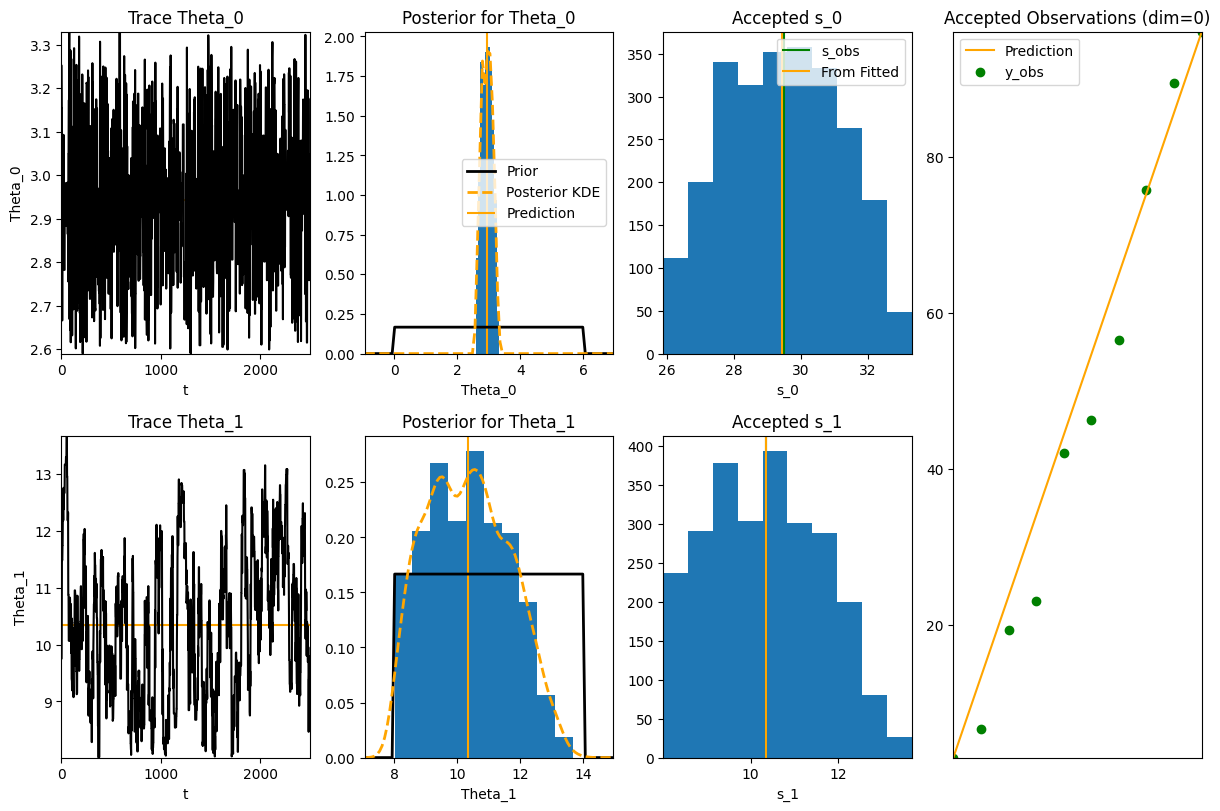

True Model - 1.000+10.000*x0+N(0,30.000)
Fitted Model - 2.943+10.341*x0

Wall time: 26.8 s


In [17]:
%%time
# MCMC
np.random.seed(16111998) # Fix random seed
fitted_model,_=ABC.abc_mcmc(n_obs=10,y_obs=lm.observe(),fitting_model=lm.copy([1,1]),priors=lm_priors,
    chain_length=2500,perturbance_kernels=perturbance_kernels,acceptance_kernel=ABC.uniform_kernel,scaling_factor=4,
    summary_stats=summary_stats)
print("True Model - {}".format(lm))
print("Fitted Model - {}\n".format(fitted_model))

*Comments*

A short burn-in was required (only 14 steps) and 41.7\% of simulations during the MCMC step were accepted.

The returned fitted model is $\hat{f}(X)=2.943+10.334$. The fit from this model is almost identical to that from ABC-Rejection Sampling. Moreover, the posteriors (Col. 2) for both parameters are very similar to those produced by ABC-Rejection Sampling.

The traces (LHS) show that a significant amount of mixing and a good level of convergence has occurred. The trace for $\theta_0$ shows better convergence than the trace for $\theta_1$, which reflects the posteriors produced.

<a id="mcmc_exponential_model"></a>
**Exponential Model**

The true model is $f(X)=2\exp\{3X/10\}+\varepsilon$ where $\varepsilon\sim\mathcal{N}(0,1)$. and my theorised model is $f_\theta(X)=\theta_0\exp\{\theta_1X\}$.

In [18]:
# Define Summary Statistics
start = (lambda ys:[ys[0][0]])
mean_log_grad = (lambda ys:[10*np.mean([np.log(max(1,ys[i+1][0]-ys[i][0])) for i in range(len(ys)-1)])])
summary_stats=[start,mean_log_grad]

Found Start - (4) [2.2653284758982424, 0.25975879633426324]   
0.459 observations were new.


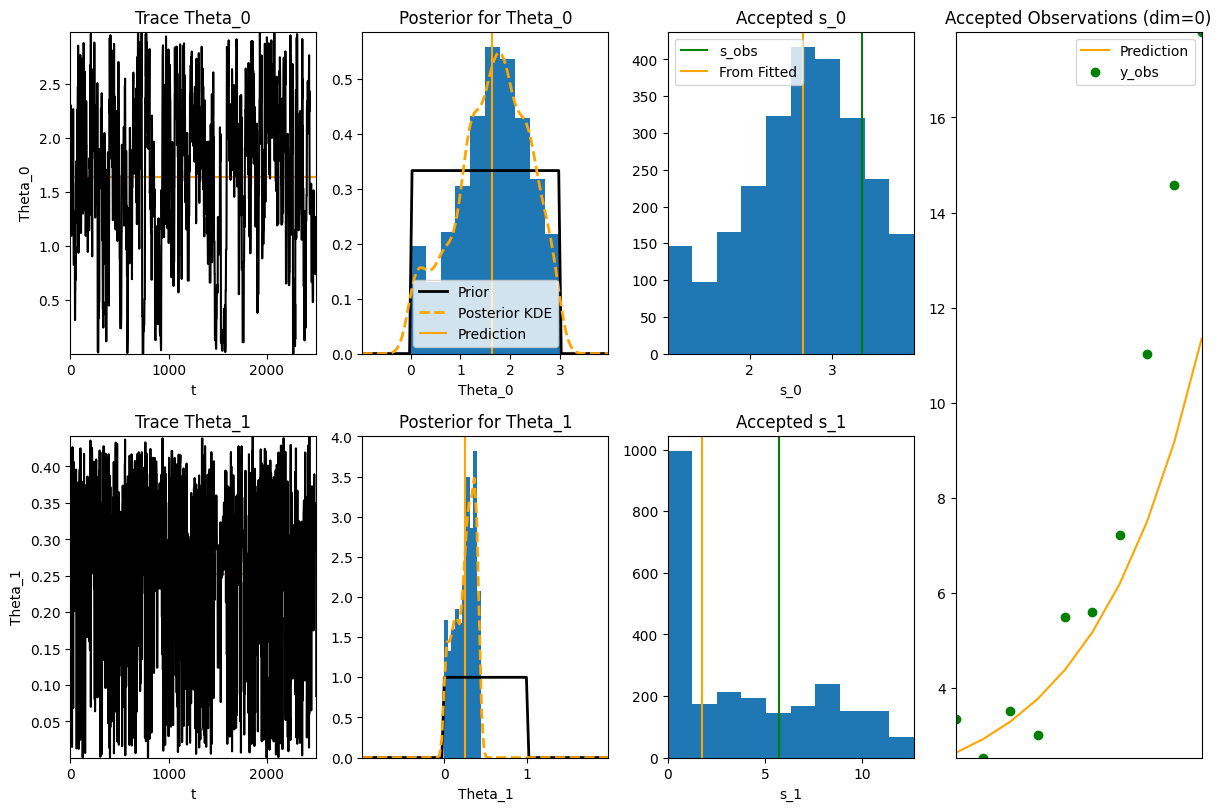

True Model - 2.000*e^(0.300*x0)+N(0,1.000)
Fitted Model - 1.642*e^(0.253*x0)

Wall time: 30 s


In [19]:
%%time
# MCMC - Chain length=2000
np.random.seed(16111998) # Fix random seed
fitted_model,_=ABC.abc_mcmc(n_obs=10,y_obs=em.observe(),fitting_model=em.copy([1,1]),priors=em_priors,
    chain_length=2500,perturbance_kernels=perturbance_kernels,acceptance_kernel=ABC.uniform_kernel,scaling_factor=7,
    summary_stats=summary_stats)
print("True Model - {}".format(em))
print("Fitted Model - {}\n".format(fitted_model))

*Comments*

The burn-in for this model is shorter than for the linear model (14 vs 4), but both are very short, and 45.9% of simulations were accepted during the MCMC-step

The returned fitted model is $\hat{f}=1.642\exp(0.253X)$. This is a slightly worse for both parameters than when ABC-Rejection Sampling was applied, although still a very good fit.

The posterior (Col 2.) for $\theta_0$ is notable more concentrated than that produced by ABC-Rejection Sampling, while the posterior for $\theta_1$ is not as concentrated. The posterior for $\theta_1$ is still much more concentrated than that for $\theta_0$ suggesting that it is more important to model fit. The traces (LHS) reiterate this by showing a greater level of convergence for $\theta_1$.


### ABC-SMC
The Sequential Monte Carlo (SMC) version of ABC aims to search the parameter space in a much more informed way than ABC-Rejection Sampling.

The general premise of ABC-SMC is to initially use a loose acceptance kernel to produce an initial sample of the parameter space, and then to refine this sample by resampling (with perturbance) and tightening the acceptance kernel.

ABC-SMC has the same features to be defined as ABC-MCMC, as well as a set of ever-tightening bandwidths $\{\epsilon_1,\dots,\epsilon_T\}$ for the acceptance kernel. A different bandwith should be defined for each resampling iteration.

ABC-SMC returns a sets of parameters along with a weight for each set, the weights correspond to the posterior weight for each parameter set.

**Algorithm**

Consider the setup described [above](#Components-of-ABC), a perturbance kernel $K^*(\cdot)$ and a set of bandwiths $\{\epsilon_0,\dots,\epsilon_T\}$. Here is an algorithm for ABC-SMC, with a sample size of $N$
<ol>
    <li>Calculate the summary statistic values $s_{obs}$ from the observed data $Y_{obs}$
    $$ s_{obs}=s(Y_{obs}) $$</li>
    <li><i>Initial Sampling</i> - Set $t=0$ and $i=0$.</li>
    <ol>
        <li>Sample a set of parameters $\tilde\theta_{0,i}$ from the priors $\pi_0(\theta)$
        $$ \tilde\theta_{0,i}\sim\pi_0(\theta) $$</li>
        <li>Initialise the theorised model $f_{\tilde\theta_{0,i}}$ with the sampled parameters $\tilde\theta_{0,i}$ and simulate data $Y_{0,i}$
        $$ Y_{0,i}\sim f_{\tilde\theta_{0,i}}(Y) $$</li>
        <li>Calculate the summary static values $s_{0,i}$ for the simulated data $Y_{0,i}$.
        $$ s_{0,i}=s(Y_{0,i}) $$</li>
        <li>Accept this simulation with probability $K_{\epsilon_0}(\|s_{0,i}-s_{obs}\|)$. If the simulation is accepted: increment $i$, store the sampled parameters $\tilde\theta_{0,i}$ in set $\Theta_0$ and set weight $w_{0,i}=1/N$.</li>
        <li>If $i\equiv N$: set $i=0$, increment $t$ and move to <i>3. Resampling</i>.</li>
    </ol>
    <li><i>Resampling</i></li>
    <ol>
        <li>Sample a set of parameters $\tilde\theta_{t,i}$ from set $\Theta_{t-1}$ with each element in $\Theta_{t-1}$ weighted by $w_{t-1,j}$</li>
        $$ \mathbb{P}(\tilde\theta_{t,i}=\theta_j)=w_{t-1,j}\ \forall\ \theta_j\in\Theta_{t-1} $$</li>
        <li>Peturb the sampled parameters $\tilde\theta_{t,i}$ to produce new parameter set $\theta_{t,i}^*$
        $$ \theta_{t,i}^*=K^*(\tilde\theta_{t,i}) $$</li>
        <li>If $\theta_{t,i}^*$ is impossible under our prior $\pi_0(\theta)$ then return to step 3. A. (otherwise, continue).</li>
        <li>Initialise the theorised model $f_{\theta_{t,i}^*}$ with the perturbed parameters $\theta_{t,i}^*$ and simulate data $Y_{t,i}$
        $$Y_{t,i}\sim f_{\theta^*}(Y)$$</li>
        <li>Calculate the summary statistic values $s_{t,i}$ for the simulated data $Y_{t,i}$
        $$s_{t,i}=s(Y_{t,i})$$</li>
        <li>Accept the simulation with probability $K_{\epsilon_t}(\|s_{t,i}-s_{obs}\|)$. If the simulation is accepted, increment $i$, store the perturbed parameters $\theta_{t,i}^*$ in set $\Theta_t$ with weight $\tilde{w}_{t,i}$. If the simulation is rejected, return to step 3. A.
         $$ \tilde{w}_{t,i}=\dfrac{\pi_0(\theta_{t,i}^*)}{\sum_{j=1}^Nw_{t-1,j}\mathbb{P}(K^*(\tilde\theta_{t,i})=\theta_{t,i}^*)} $$</li>
        <li>If $|\Theta_t|<N$: return to step 3. A.</li>
        <li> Normalise weights $\tilde{w}_{t,i}$ st they form a probability distribution
        $$ w_{t,i}:=\dfrac{\tilde{w}_{t,i}}{\sum_{i=1}^Nw_{t,i}} $$
        </li>
        <li>If $t<T$: Increment $t$, otherwise move to step 4.</li>
    </ol>
    <li>Return the final sample along with their respective weights $\{(\theta_{T,1},w_{T,1}),\dots,(\theta_{T,N},w_{T,N})\}$</li>
</ol>

<a id="smc_implementation"></a>
### Implementation
Here I implement the ABC-SMC algorithm and apply it to the same [model](#Models.LinearModel) & [exponential model](#Models.ExponentialModel) as I did for the [ABC-Rejection Sampling](#rejection_implementation) * [ABC-MCMC](#ABC-MCMC). To allow for a fair comparison of the algorithms I am using the same *Summary Statistics* and *Priors* for each model.

In both cases, I run the algorithm with a sample size of $N=100$ and define a set of 10 different bandwiths which evenly partition the interval $[.5,3]$.

In my implementation of ABC-SMC I require that the set of bandwidths $\{\epsilon_0,\dots,\epsilon_T\}$ are defined explicitly and passed to the function as a parameter. However, this is not technically necessary. "Automatic" variations of ABC-SMC can allow for the bandwidths to be choosen after each iteration, with the value being chosen such that the next step has a desired expected acceptance rate. These variations require the definition of stopping conditions for when it is believed the posterior has converged sufficiently.

**Warning** I have not set up the implementations below st they make approximately the same number of simulations as the implementations above, meaning it is unfair to compare the outcomes of these different implementations. I have done this as otherwise the uniqueness of ABC-SMC would not be apparent. As a result, the implementations below take a lot longer to run than the implementations of ABC-MCMC and ABC-Rejection Sampling.

**Perturbance Kernels**

The comments for perturbance kernels for ABC-SMC are very similar to [those for ABC-MCMC](#mcmc_perturbance), except:
 * You need to be able the probability that the kernel produces a certain value given the input as this is needed to weight each sample.
 * Tuning of the perturbance kernels should be done in tandem with tuning the set of bandwidths.

In [20]:
perturbance_variance=.1

perturbance_kernels = [lambda x:x+stats.norm(0,perturbance_variance).rvs(1)[0]]*2
perturbance_kernel_probability = [lambda x,y:stats.norm(0,perturbance_variance).pdf(x-y)]

**Bandwidths**

There are several considerations when choosing a set of bandwidths for ABC-SMC. Not only the values, but also how many bandwidths to use. More bandwidths require more computational power, but will lead to a smoother convergence. Looser bandwidths mean more simulations will be accepted, reducing computational load, but the resulting estimate of the posterior will be more approximate. Greater decreases between consequitive bandwidths will likely require more computational power as the refinements to the posterior required are greater (TODO - totally reword this).

In [21]:
scaling_factors=list(np.linspace(3,.5,10))

<a id="smc_linear_model"></a>
**Linear Model**

The true model is $f(X)=1+10X+\varepsilon$ where $\varepsilon\sim\mathcal{N}(0,30)$ and my theorised model is $f_\theta(X)=\theta_0+\theta_1X$.

In [22]:
# Define summary statistics
np.random.seed(16111998) # Fix random seed
start = (lambda ys:[10*ys[0][0]])
mean_grad = (lambda ys:[np.mean([ys[i+1][0]-ys[i][0] for i in range(len(ys)-1)])])

(213) - 100/100
(9/10 - 320) - 99/100 (0.500)
Total Simulations - 2,043
theta_hat - [2.9754454802781316, 8.724296003074299]


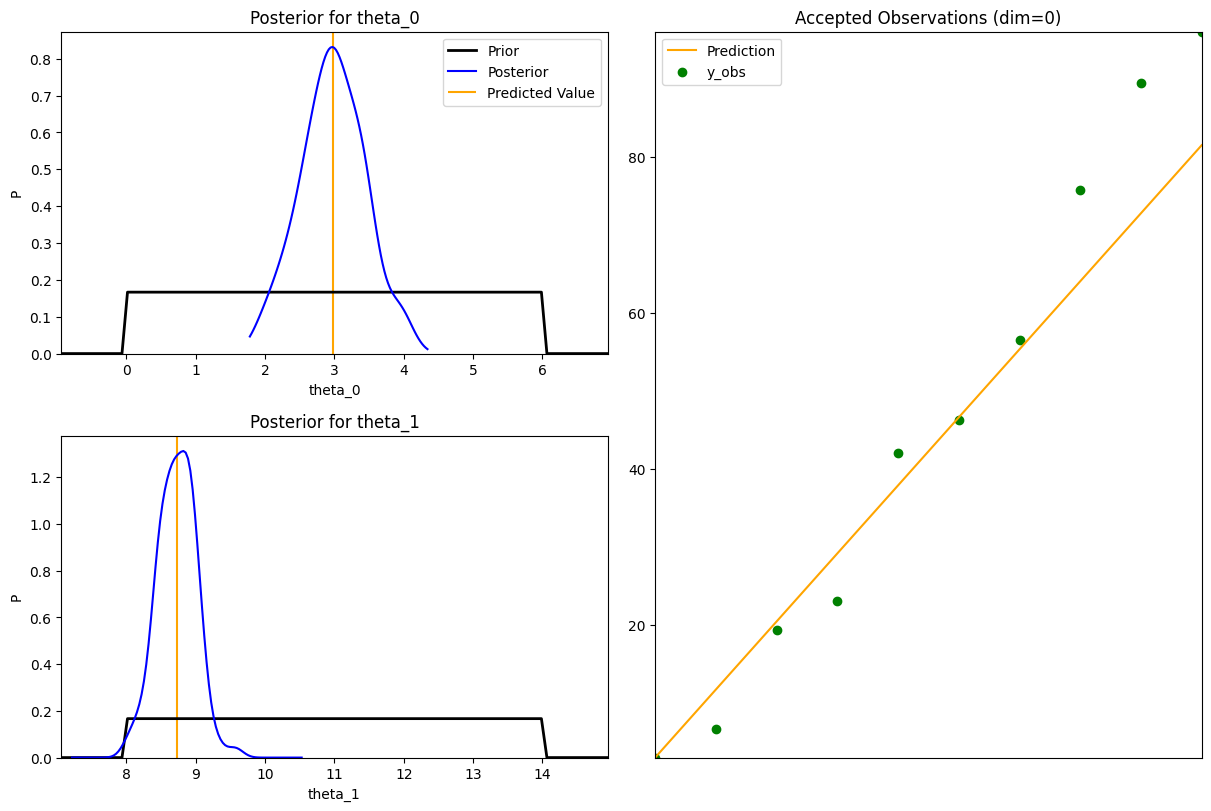

True Model - 1.000+10.000*x0+N(0,30.000)
Fitted Model - 2.975+8.724*x0

Wall time: 1min 46s


In [23]:
%%time
# SMC - Sample Size=100
fitted_model,_=ABC.abc_smc(n_obs=10,y_obs=lm.observe(),fitting_model=lm.copy([1,1]),priors=lm_priors,
    num_steps=10,sample_size=100,scaling_factors=scaling_factors,perturbance_kernels=perturbance_kernels,perturbance_kernel_probability=perturbance_kernel_probability,acceptance_kernel=ABC.gaussian_kernel,summary_stats=summary_stats)

print("True Model - {}".format(lm))
print("Fitted Model - {}\n".format(fitted_model))

*Comments*

823 simulations were required to produce the initial sample $\Theta_0$ and a total of 3,064 simulations were required to complete the algorithm.

The fitted model is $\hat{f}(X)=2.907+10.350X$. This is a good fit, especially when considering the noise in the model and how it affects $\hat\theta_0$.

Comparing the priors and posteriors (cols 1,2) shows that significant learning has occurred, more than the other implementations. Notably, this is the only implementation which has indicated significantly learning for $\theta_0$, the reason for this is worth investigating (Likely due to confirmation bias from resampling, but potentially due to significantly increase in number of simulations performed).

**Note** I have produced fewer plots here than for ABC-Rejection Sampling and ABC-MCMC as it is harder to succicently visualise the data generated at each step whilst being able to distinguish between each step (and the amount of data produced). I do have some ideas, promise.

<a id="smc_exponential_model"></a>
**Exponential Model**

The true model is $f(X)=2\exp(3X/10)+\varepsilon$ where $\varepsilon\sim\mathcal{N}(0,1)$ and my theorised model is $f_\theta(X)=\theta_0\exp(\theta_1X)$.

In [24]:
# Define summary statistics
start = (lambda ys:[ys[0][0]])
mean_log_grad = (lambda ys:[10*np.mean([np.log(max(1,ys[i+1][0]-ys[i][0])) for i in range(len(ys)-1)])])
summary_stats=[start,mean_log_grad]

(879) - 100/100
(9/10 - 2,219) - 99/100 (0.500)
Total Simulations - 8,479
theta_hat - [2.358781176443555, 0.3277078726143601]


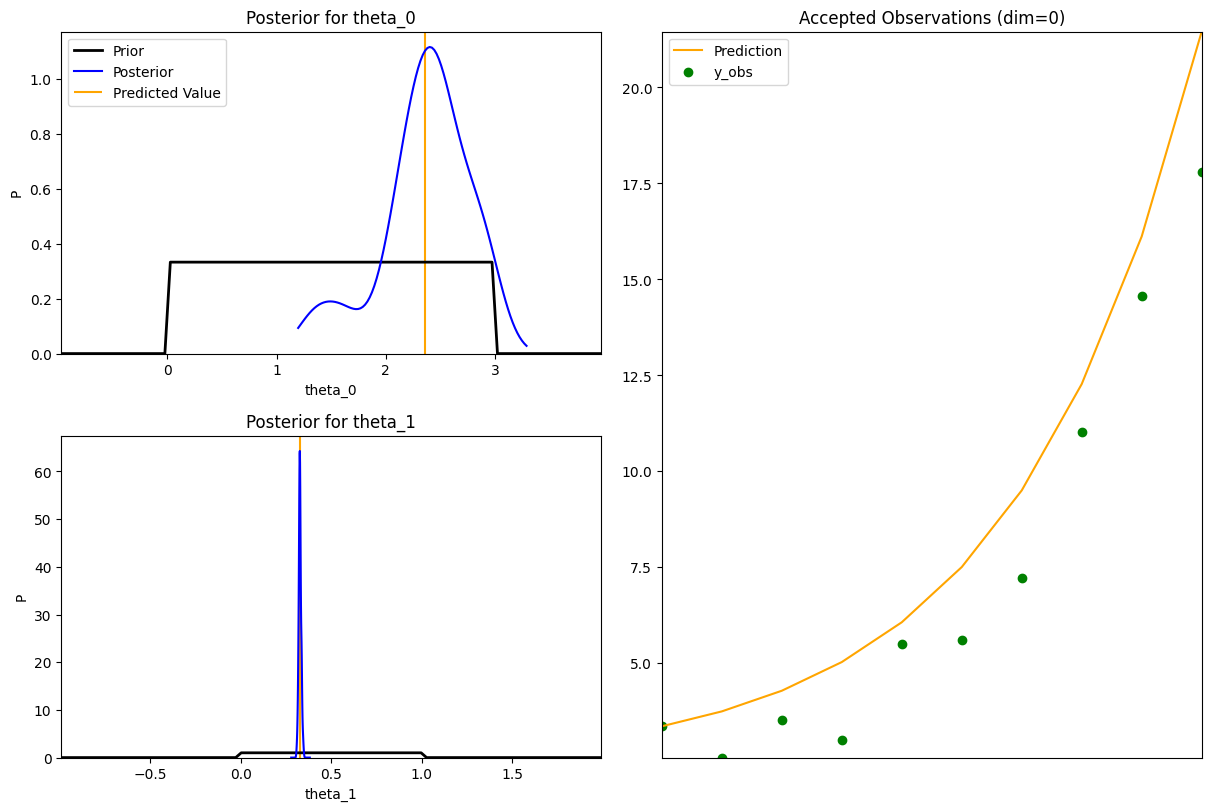

True Model - 2.000*e^(0.300*x0)+N(0,1.000)
Fitted Model - 2.359*e^(0.328*x0)

Wall time: 2min 54s


In [25]:
%%time
# SMC - Sample Size=100
np.random.seed(16111998) # Fix random seed
fitted_model,_=ABC.abc_smc(n_obs=10,y_obs=em.observe(),fitting_model=em.copy([1,1]),priors=em_priors,
    num_steps=10,sample_size=100,scaling_factors=scaling_factors,perturbance_kernels=perturbance_kernels,perturbance_kernel_probability=perturbance_kernel_probability,acceptance_kernel=ABC.gaussian_kernel,summary_stats=summary_stats)

print("True Model - {}".format(em))
print("Fitted Model - {}\n".format(fitted_model))

*Comments*

2,050 simulations were required to produce the initial sample $\Theta_0$ and a total of 15,052 simulations were required to complete the algorithm. This is significantly more than were required for the linear model, showing how even a relatively small increase in model complexity affects ABC-SMC's performance.

The fitted model is $\hat{f}(X)=2.367\exp(0.305X)$. This is a very good fit, especially for $\hat\theta_1$ (the more important parameter).

Similar to the linear model, comparing priors and posteriors (cols. 1,2) show significant learning has occurred. Especially for $\theta_1$ where the posterior density is extremely concentrated. The reasons for the posterior for $\theta_0$ showing signifcant learning are likely the same as discussed for the linear model implementation.

## Discussion

### Advantages
ABC methods have many desirable qualities, not only mathetmatical, but practical and computationall too
 * **Parallelisable** - In ABC-Rejection Sampling each simulation is independent so we can make us of parallelisation when implementing in order to speed up the algorithm. This is particularly notable as many super-computers are optimised for parallelisable algorithms. In ABC-MCMC each simulation is dependent upon the previous one but parallelisation can still be used to run multiple chains in parallel, allowing for greater exploration. In ABC-SMC simulations in the same iteration are independent and thus parallelisation can be used.
 
 * **Can Estimate Bayes Factor Directly** - Bayes factor $B_{1,2}$ is a metric used to compare two models $M_1,M_2$ for model selection and is defined as the ratio of the "evidence" for the two models. If $B_{1,2}>3$ there is good evidence for $M_1$ over $M_2$ and if $B_{1,2}<1$ there is evidence for $M_2$ over $M_1$. ABC-Rejection Sampling can be used to estimate Bayes factor by: each simulation choosing one of the two models uniformly at random; simulating from it and recording how many times samples were accepted from each model. The ratio of these two counts is an estimator of the Bayes factor. (Better methods are proposed in *Likelihood-free estimation of model evidence* by Didelot, Everitt†, Johansen and Lawson).
 $$ B_{1,2}(D)=\frac{\mathbb{P}(D|M_1)}{\mathbb{P}(D|M_2)}=\frac{\mathbb{P}(M_1|D)\mathbb{P}(M_2)}{\mathbb{P}(M_2|D)\mathbb{P}(M_1)} $$
 
 * **Adaptable** - ABC methods can, in general, be easily adapted to different problem scenarios due to their reliance on simulation and comparision which are very basic properties and are available in most scenarios.
 
 * **Automatable** - A disadvantage of ABC methods is that the user's choice of summary statistics, distance measures and kernels will affect the outcome and different choices are better for different problems. However, implementation choices can be made st some of these hyperparameter choices are automated. I discuss how this can be done for summary statistics in [SS_Notebook](SS_Notebook.ipynb). For the kernel, one approach is to (rather than define a bandwidth) is to define what proportion of samples you wish to be accepted and then for you implementation to adjust the bandwidth such that this number is reached. Alternatively, you could adjust the perturbance kernels used in ABC-MCMC and ABC-SMC to achieve similar results.
 
 * **Likelihood-Free** - Most statistical inference relies on the use of a likelihood function, however there are many important real world scenarios when an explicit likelihood function does not exist. ABC methods are able to cope with these scenarios and thus expand the set of problems which statistical inference can be applied to.

* **Easy to Implement**.

### Limitations
Here I describe some limitations which are common in ABC methods (and in some cases ways to mitigate these limitations)

 * **Computationally Inefficient** - The more often an ABC method samples parameters from an area of non-neglibe likelihood, the more efficient the algorithm is as meaningful inferences can be made. The ABC-Rejection Sampling algorithm is not good for this as each parameter sample is independent and the algorithm has no mechanic which stops it from resampling parameters which are known to be rejected. The ABC-MCMC and ABC-SMC methods are more efficient as they are search algorithms and aim to stay in areas of high likelihood. However, this does mean that they struggle to produce an accurate estimate of the posterior in cases when the posterior is multi-modal. This can be mitigate by running multiple chains/instances of each algorithm but this requires greater computational resources.
 
 * **Understanding Summary Statistics** - It is often hard to predict the effects of summary statistics due to the mutual relationship between summary statistics often being complicated and poorly understood themselves. Moreover, good choices of summary statistics may not be as similiar for similiar problems as may be expected, and the choices of summary statistic which do perform well may not necessarily have a clear logic as to why (Especially when using the approximate sufficiency method proposed by Joyce & Marjoram). (As always, correlation is not causation).
 
 * **Priors for Complex Models** - The further a prior is from the posterior the worse the performance of ABC methods. As the complexity of a model increases the more likely it is for the priors to be far away from the posterior (Curse of dimensionality). The easiest solution to this is to use wider priors but this means more samples will be rejected. Alternatively, making use of expert knowledge to chose priors is very good but will limit your choice of summary statistics to those which are well understood and may introduce bias.
 
 * **Choices Matter** - ABC methods have many hyper-parameters (inc. distance measure, summary statistics & kernel) and these can all have a massive effect on the performance of the algorithm. As mentioned in *Understanding Summary Statistics* it is generally very difficult to accurately predict the effect our choices for these hyperparameters will have. They have been propositions of Automatic and Semi-Automatic ABC methods where, instead of speficing these hyper-parameters, we specify a criteria (e.g. 10% of simulations being accepted) and then the algorithm automatically sets & updates these hyperparameters to achieve this criteria.
 
 * **Sufficient Statistics** - If sufficient summary statistics do not exist for our model then the produced posterior is only every an approximation of the true posterior. (Talk about Pitman–Koopman–Darmois Theorem).
 
 * **Loss of Information** - When insufficient summary statistics are used there is an unknown loss in information. This can often lead to inconsistency, and in the worst cases (where lots of information is lost) can lead to statistical invalid conclusions. (https://www.pnas.org/content/108/37/15112)

 * **Auto-correlation** - Auto-correlation is the correlation of a signal with a earlier verion of itself. This cannot occur in ABC-Rejection Sampling as all the samples are independent (although a dodgy prior may cause similar issues?), but is highly likely in MCMCM chains. Acceptance kernels which accept to many or too few simulations will produce auto-correlated MCMC chains (~30-70%) is desirable. If our statistical inference assumes that each simulation is independent, auto-correlation can invalid this assumption and thus any inferences we draw.

### When problems occur
 * **Models with Multi-Modal Likelihoods & Posteriors** - Mixture models are a popular statistical model, but inference for them is hard due to their multi-modal likelihoods & posteriors. Bayesian inference on these models generally rely on MCMC methods but this leads to "label switching problem". This is the problem where the posterior is invariant under relabelling of the underlying distributions, this can lead the MCMC chain for each mean to flip which one they are searching for etc. This is fairly easy to demonstrate. <br>Moreover, most common summary statistics (e.g. mean) are useless. In *Approximate Bayesian computation for finite mixture models* Simola , Cisewski-Kehe & Wolpert propose an extension to ABC-PMC which is designed to tackle this sort of models.

# Demonstrations

## Models with Multi-Modal Likelihoods & Posteriors
Here I apply ABC methods to a Gaussian Mixtures Model (GMM). A GMM has a multi-modal posterior. The precise model I am going to use is the one presented by in Simola , Cisewski-Kehe & Wolpert *Approximate Bayesian computation for finite mixture models*.

**The Model**

This model simulates 40 data points with the first 20 from distribution $X_1$ and the second 20 from distribution $X_2$, defined as
$$ X_1\sim\text{Normal}(-20,1)\quad X_2\sim\text{Normal}(20,1) $$
This means the weight from each gaussian is $.5$.

I am using the `GaussianMixtureModel_two` from `models.py`, which allows for a GMM with two gaussian and assumes the variances of known.

In [26]:
from Models import GaussianMixtureModel_two

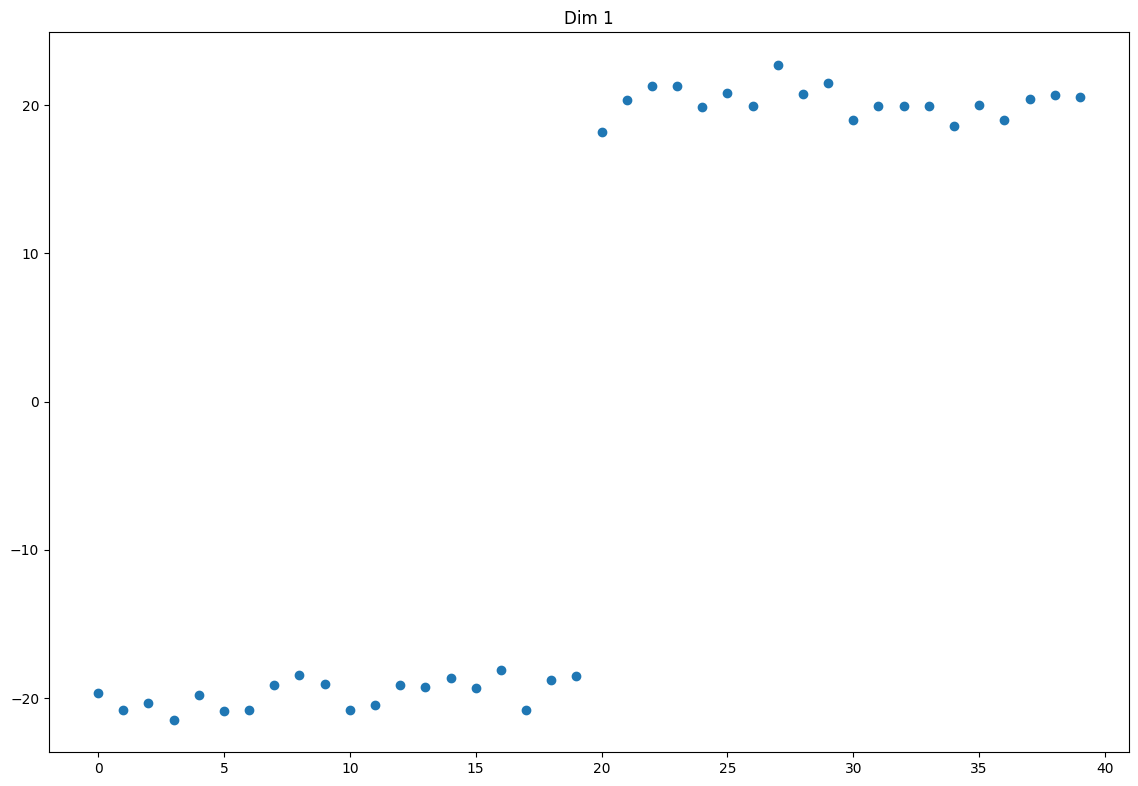

In [27]:
# define gmm
np.random.seed(16111998) # Fix random seed
gmm=GaussianMixtureModel_two(
    params=(-20,20,.5),
    n_obs=40,
    sd=(1,1))
gmm.plot_obs()

**Priors**

I assume that the variances of each gaussian is known, this means there are three model parameters to learn
<ol>
    <li>$\mu_1$ - The mean of $X_1$.</li>    
    <li>$\mu_2$ - The mean of $X_2$.</li>
    <li>$w$ - The weight given to $X_1$.</li>
</ol>
Note that the weight given to $X_2$ is not a model-parameter as it is always $1-w$ due to the definition of a GMM.

For the priors I use suggested in the paper
$$\begin{array}{rcl}
    \pi_0(\mu_1)&\sim&\text{Normal}(0,100)\\
    \pi_0(\mu_2)&\sim&\text{Normal}(0,100)\\
    \pi_0(w)&\sim&\text{Beta}(1,1)
\end{array}$$
Note that $\text{Beta}(1,1)$ is the same as $Uniform[0,1]$.

In [28]:
# define priors
gmm_priors=[stats.norm(loc=0,scale=10),stats.norm(loc=0,scale=10),stats.beta(1,1)]

**ABC Method**

Due to its popularity, I apply ABC-MCMC to learn these model parameters with a chain length of 10,000. For the summary statistics I use the identity function as other choices may influence the results. A gaussian acceptance kernel with bandwith $\varepsilon=100$ is used, this bandwidth was tuned st the acceptance rate was ~40%.

For the perturbance kernels I use additive gaussian noise with $sd=0.3$ for $\mu_1,\mu_2$ and with $sd=0.1$ for $w$.

In [29]:
# define perturbance kernels
perturbance_kernels = [lambda x:x+stats.norm(0,.3).rvs(1)[0]]*2+[lambda x:x+stats.norm(0,.1).rvs(1)[0]]

Found Start - (5) [6.089915126662313, 8.659476748373306, 0.7885293956259145]
0.409 observations were new.


D:\Documents\Maths\Masters-Project\Code\ABC.py:368: RuntimeWarning: divide by zero encountered in long_scalars
  row_step=n_rows//n_simple_ss


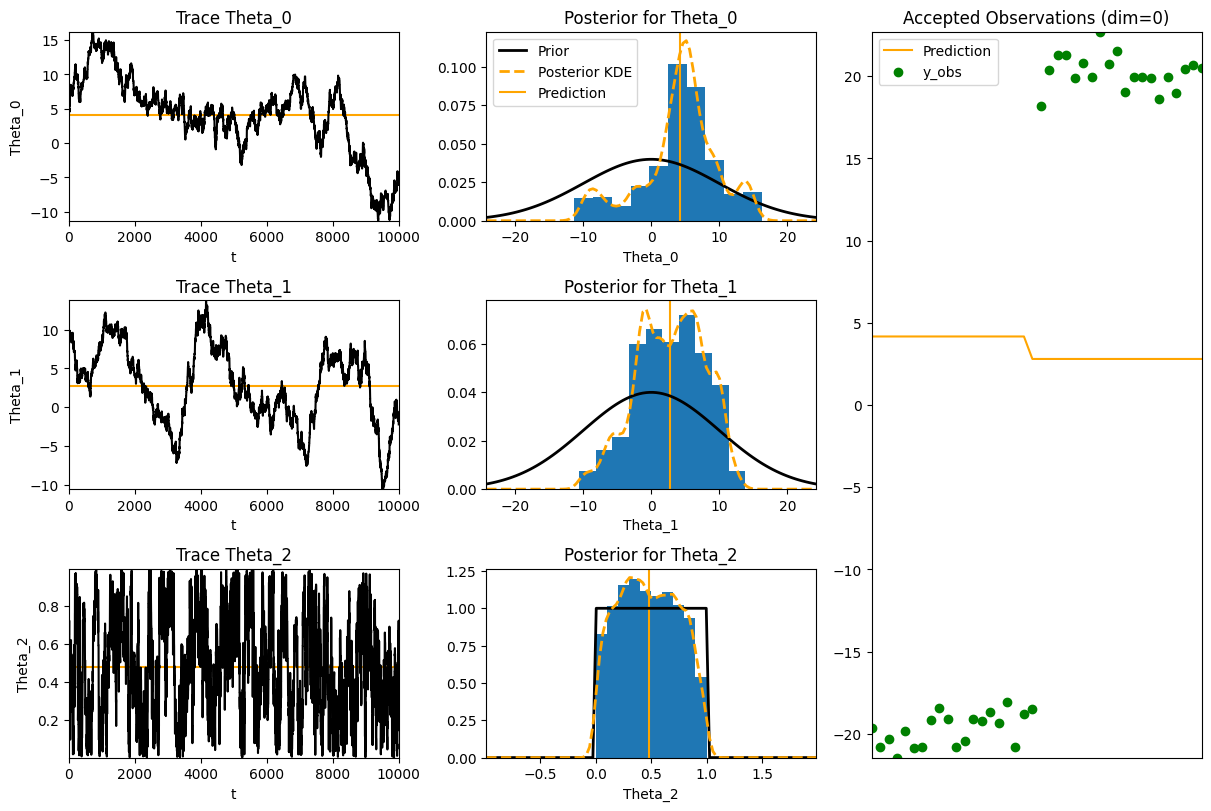

True Model - X_1~Normal(-20.000,1.000)
X_2~Normal(20.000,1.000)
X=0.500*X_1+0.500*X_2
Fitted Model - X_1~Normal(4.167,1.000)
X_2~Normal(2.799,1.000)
X=0.478*X_1+0.522*X_2

Wall time: 59.8 s


In [30]:
%%time
# ABC-MCMC for GMM
np.random.seed(16111998) # Fix random seed
fitted_model,_=ABC.abc_mcmc(n_obs=40,y_obs=gmm.observe(),fitting_model=gmm.copy([1,1,1]),priors=gmm_priors,
    chain_length=10000,perturbance_kernels=perturbance_kernels,acceptance_kernel=ABC.gaussian_kernel,scaling_factor=100)
print("True Model - {}".format(gmm))
print("Fitted Model - {}\n".format(fitted_model))

*Comments*

The resulting fit here is very poor, and the fitted parameters are not far from the mean of their priors. This indicates that very little learning has occurred.

The traces (LHS) for $\theta_1=\mu_2$ shows the signs of the "label switching problem" due to it appearing to cycle between two equilibria.

## Insufficient Statistics
There are multiple points in ABC methods where approximation is introduced, one is in the summary statistics. I discuss the reasons for this in depth in [SS_Notebook](SS_Notebook.ipynb).

There are automatic variations of ABC methods which seek to rectify this by taking the decision on summary statisics away from the operator. This methods are generally split into two:
<ol>
    <li>Projection Methods - A non-linear projection is performed on data to a lower dimensional space whilst trying to maintain certain characteristics of the data set.</li>
    <li>Automatic Methods - The operator provides a large set of summary statistics from which the algorithm chooses a subset which fulfils some optimality condition wrt sufficiency.</li>
</ol>

Here I shall simply demonstrate that if you use un-informative and in-sufficient summary statistics then the performance of ABC methods quickly deteriorates. To emphasise this I shall use the most uninformative statistics, random noise.

More precisely, for each simulation I generate a value from $\text{Normal}(0,10^2)$ and use that as the summary statistic for that simulation. This value is completely independent of the simulated data and thus totally informative. I run the "Best Samples" version of the ABC-Rejection algorithm using this summary statistic and have widenned the priors in order to emphases how poor the performance is.

$$ \pi_0(s_1)\sim\text{Uniform}[-10,10]\quad\pi_0(s_2)\sim\text{Uniform}[-10,10] $$

Due to the summary statistic being independent of the data we expect the posteriors to be very similar to the priors and for the fitted values to be the mean of their respective prior.

In [31]:
# define insufficient statistics
summary_stats=[lambda ys:[stats.norm(0,10).rvs(1)[0]]]

(999/1,000)



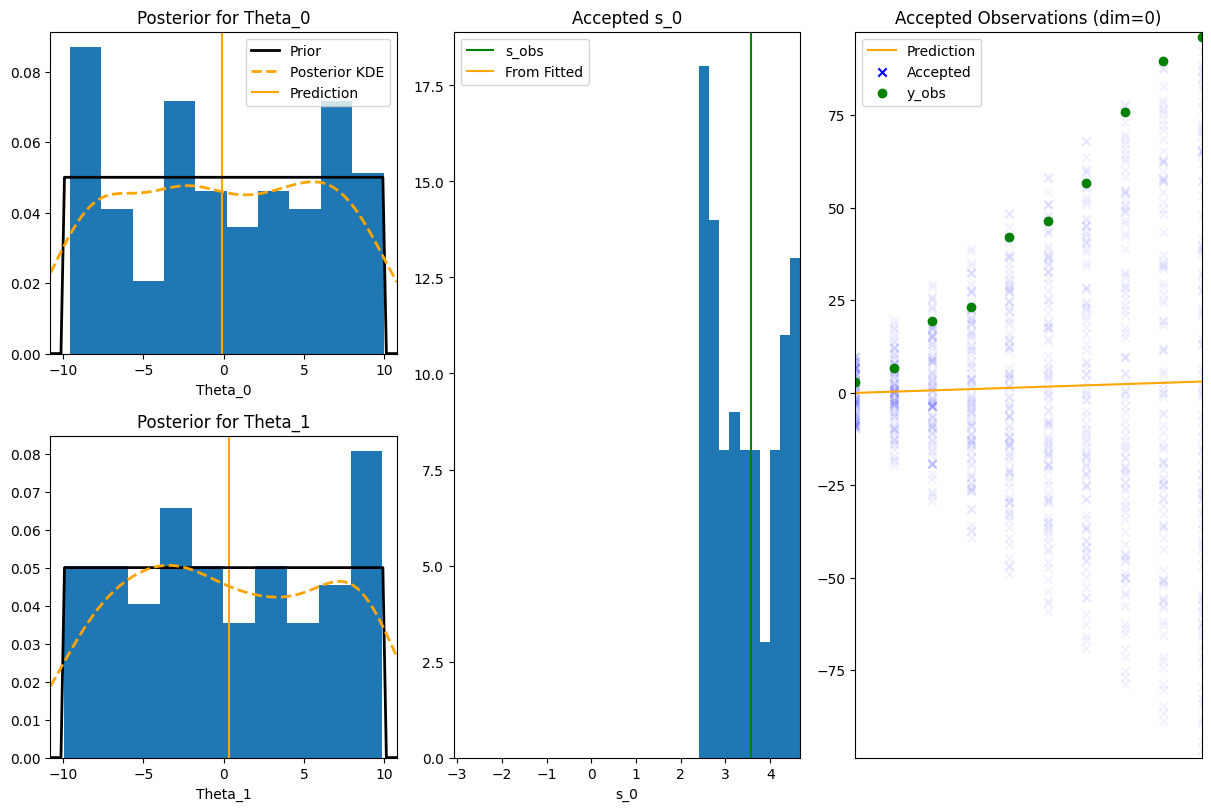

True Model - 1.000+10.000*x0+N(0,30.000)
Fitted Model - -0.076+0.341*x0

Wall time: 10.7 s


In [32]:
%%time
# First Run - FIXED NUMBER - Until 100 acceptances
np.random.seed(16111998) # Fix random seed

lm_priors=[stats.uniform(-10,20),stats.uniform(-10,20)]

sampling_details={"sampling_method":"best","num_runs":1000,"sample_size":100}

fitted_model,_=ABC.abc_rejcection(n_obs=10,y_obs=lm.observe(),fitting_model=lm.copy([1,1]),priors=lm_priors,sampling_details=sampling_details,summary_stats=summary_stats)
print("True Model - {}".format(lm))
print("Fitted Model - {}\n".format(fitted_model))

*Comments*

The fitted model is $\hat{f}(X)=-0.076+0.341X$. This is a terrible fit.

As expected the priors and posteriors are effectively the same shape, showing no learning as occurred. And, the fitted parameter values are very close to the means of their respective priors.

This demonstrates that uninformative summary statistics lead to very poor (or no learning) in some cases.

## Choices Matter
Not only does the choice of summary statistics affect the performance of ABC methods, but so do our choices for other hyper-parameters.

Here I demonstrate how a poor choice of kernel and bandwidth can lead to very poor learning. The wider the bandwidth $\varepsilon$ of the kernel the more likely simulations which are further away from the observed data is to be accepted. Thus the quality of accepted samples will decrease, but the time taken to accepted a certain number of simulations will increase.

There are adaptive variations to the ABC methods which take the choice of some hyper-parameters away from the operator. Instead, they simply require the user to specify a target range for the acceptance rate of simulations and then the algorithm will actively adapt the parameters accordingly.

Below I run "Fixed Number" variation of the ABC-Rejection sampling algorithm on the linear model, exactly as I did [before](#rejection_linear_model), except that the bandwidth on the acceptance kernel is set to $40$ rather than $4$.

In [33]:
# Define Priors
lm_priors=[stats.uniform(0,6),stats.uniform(8,6)]

# Define Summary Statistics
start = (lambda ys:[10*ys[0][0]])
mean_grad = (lambda ys:[np.mean([ys[i+1][0]-ys[i][0] for i in range(len(ys)-1)])])
summary_stats=[start,mean_grad]

(100) 100/100



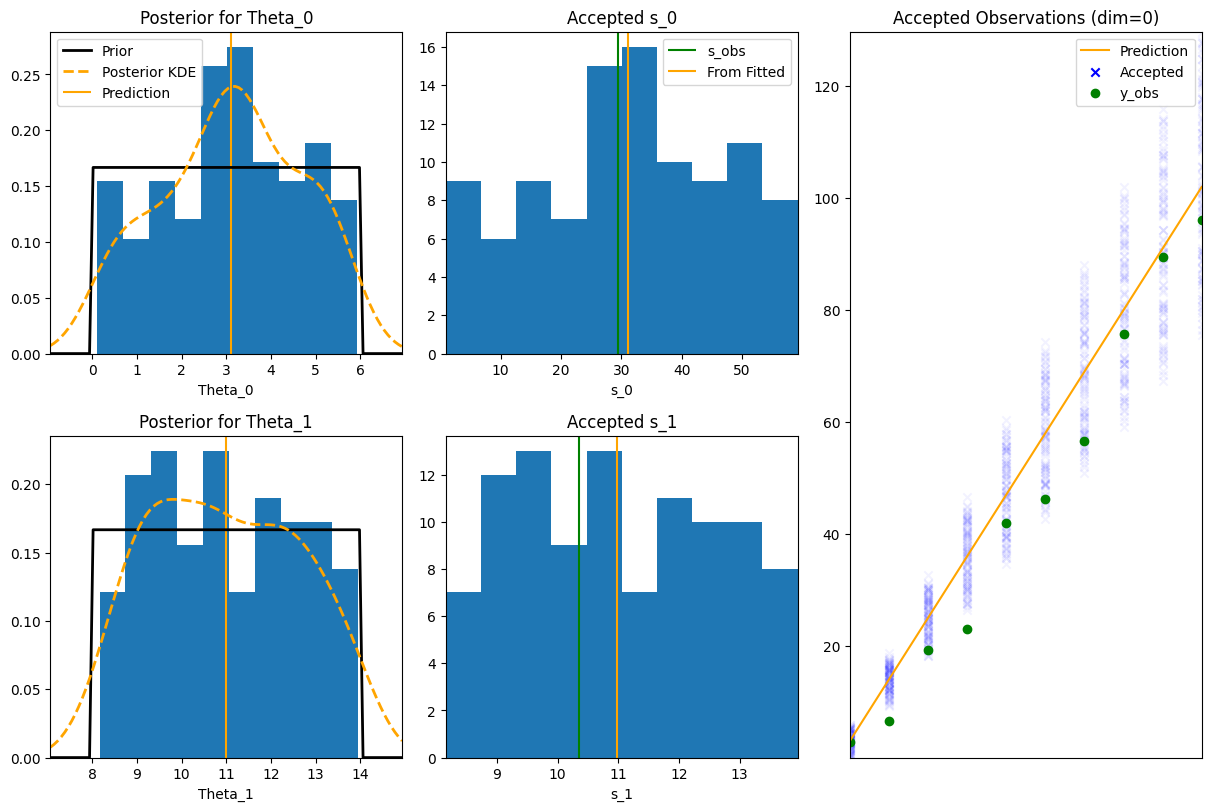

True Model - 1.000+10.000*x0+N(0,30.000)
Fitted Model - 3.105+10.982*x0

Wall time: 2.34 s


In [34]:
%%time
# First Run - FIXED NUMBER - Until 100 acceptances
np.random.seed(16111998) # Fix random seed

sampling_details={"sampling_method":"fixed_number","sample_size":100,"scaling_factor":40,"kernel_func":ABC.uniform_kernel}

fitted_model,_=ABC.abc_rejcection(n_obs=10,y_obs=lm.observe(),fitting_model=lm.copy([1,1]),priors=lm_priors,sampling_details=sampling_details,summary_stats=summary_stats)
print("True Model - {}".format(lm))
print("Fitted Model - {}\n".format(fitted_model))

*Comments*

The fitted model is $\hat{f}(X)=3.105+10.982X$. This is a terrible fit given the priors.

As expected the priors and posteriors are effectively the same shape, showing no learning as occurred. And, the fitted parameter values are very close to the means of their respective priors. This is unsurprising as all of the first 100 simulations was accepted.

## Auto-Correlation
(Look up how to demonstrate this)

# TODO
 * Priors
 * ABC-Importance Sampling
 * ABC-PMC (Population monte carlo)
 * Distance measures (L2 norm, L-infinty norm, Hellinger distance, absolute,
 * Decisions made each time
 
### Demostration
 * Insufficient statistic leads to inconsistency and invalid conclusions. (Use random noise).
 * Auto-correlation
 * Choices matter